#Problème:

#Deux cas d'utilisation des données d'opportunité

La qualité de la description d'un phénomène physique dépend des moyens d'observation disponibles. Généralement, les moyens à disposition dépendent de la zone géographique et de la période considérée.
Lorsque les capteurs sont peu nombreux, on peut chercher à compléter l'observation par des données supplémentaires issues de capteurs non spécifiques. On parle alors de *données d'opportunité*.

Les *données d'opportunité* peuvent être exploitées par apprentissage. Une approche courante consiste à entraîner un modèle sur la zone où des capteurs spécifiques peuvent fournir une cible de qualité. Le modèle est ensuite porté là où seules les *données d'opportunité* sont disponibles.

Aujourd'hui, on utilise par exemple des données issues des réseaux de télécommunication pour préciser la localisation et l'intensité de phénomènes physiques ou sociaux.  
La première partie du problème est inspirée du cas où la donnée opportune est une atténuation du signal échangé entre les antennes d'un réseau mobile.

On cherche aussi à exploiter des données issues de capteurs de mauvaise qualité qui peuvent être beaucoup plus nombreux que les capteurs spécifiques. C'est ce qu'illustre la seconde partie.

**Note**: les deux parties du problème sont complètement indépendantes.

**Partie I - problème n°1 : régression avec un UNet**

In [64]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

! nvidia-smi

Thu Jan 11 15:44:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [65]:
# Lien valable jusqu'au 17/01/2024:
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
! mkdir data
from utile_BE import *

--2024-01-11 16:37:01--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402 (27K) [application/octet-stream]
Saving to: ‘HAnmgiuVNGn_XtdcYCeMNnJ’

HAnmgiuVNGn_XtdcYCe 100%[===================>]  26.76K  --.-KB/s    in 0s      

2024-01-11 16:37:02 (232 MB/s) - ‘HAnmgiuVNGn_XtdcYCeMNnJ’ saved [27402/27402]

mkdir: cannot create directory ‘data’: File exists


Dans ce problème, la cible $T$ est un champ physique scalaire, positif ou nul. On suppose que, dans le meilleur des cas, deux types de capteurs spécifiques sont disponibles.\
Le premier type fournit une mesure spatialisée du champ. Il n'est pas partout disponible. Le second type de capteur fournit une mesure ponctuelle. Ces capteurs sont implantés sur toute la zone d'intérêt mais il ne couvrent correctement que 0.5% de la surface.\
En plus de ces capteurs, on suppose qu'on a accès à des données issues d'un réseau de télécommunications. Ces données réflètent l'atténuation d'un signal échangé entre des antennes relais. On suppose que pour chaque signal émis entre deux antennes $A_i$, $A_j$, on peut calculer une quantité $S(A_i,A_j;T)$ qui ne dépend que de la valeur moyenne du champ $T$ sur le trajet entre $A_i$ et $A_j$.

On se place dans le cas où un jeu est constitué sur la zone où la mesure spatialisée du champ est disponible. Pour une première preuve de concept, on travaille avec des images de synthèse sur lesquelles:
- les mesures ponctuelles ont été attribuées aux pixels qui leur correspondent.
- les données d'opportunité sont représentées par des segments. Les extrémités d'un segment représentent deux antennes $A_i$, $A_j$. Le long d'un segment, l'intensité des pixels est constante, de valeur $S(A_i,A_j;T)$ (seule exception, dans le cas d'intersections, les valeurs sont simplement sommées - voir ci-dessous).

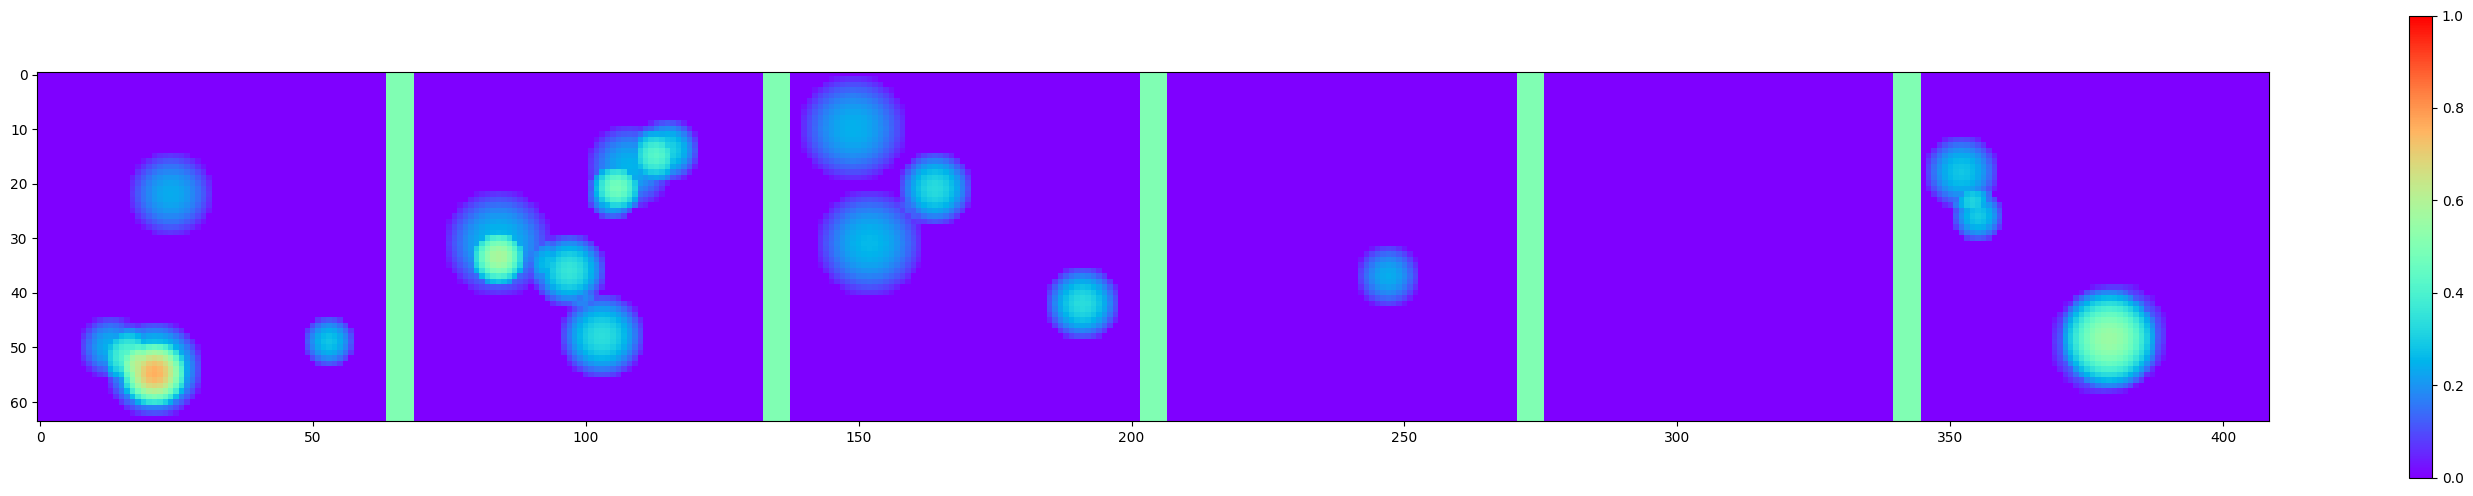

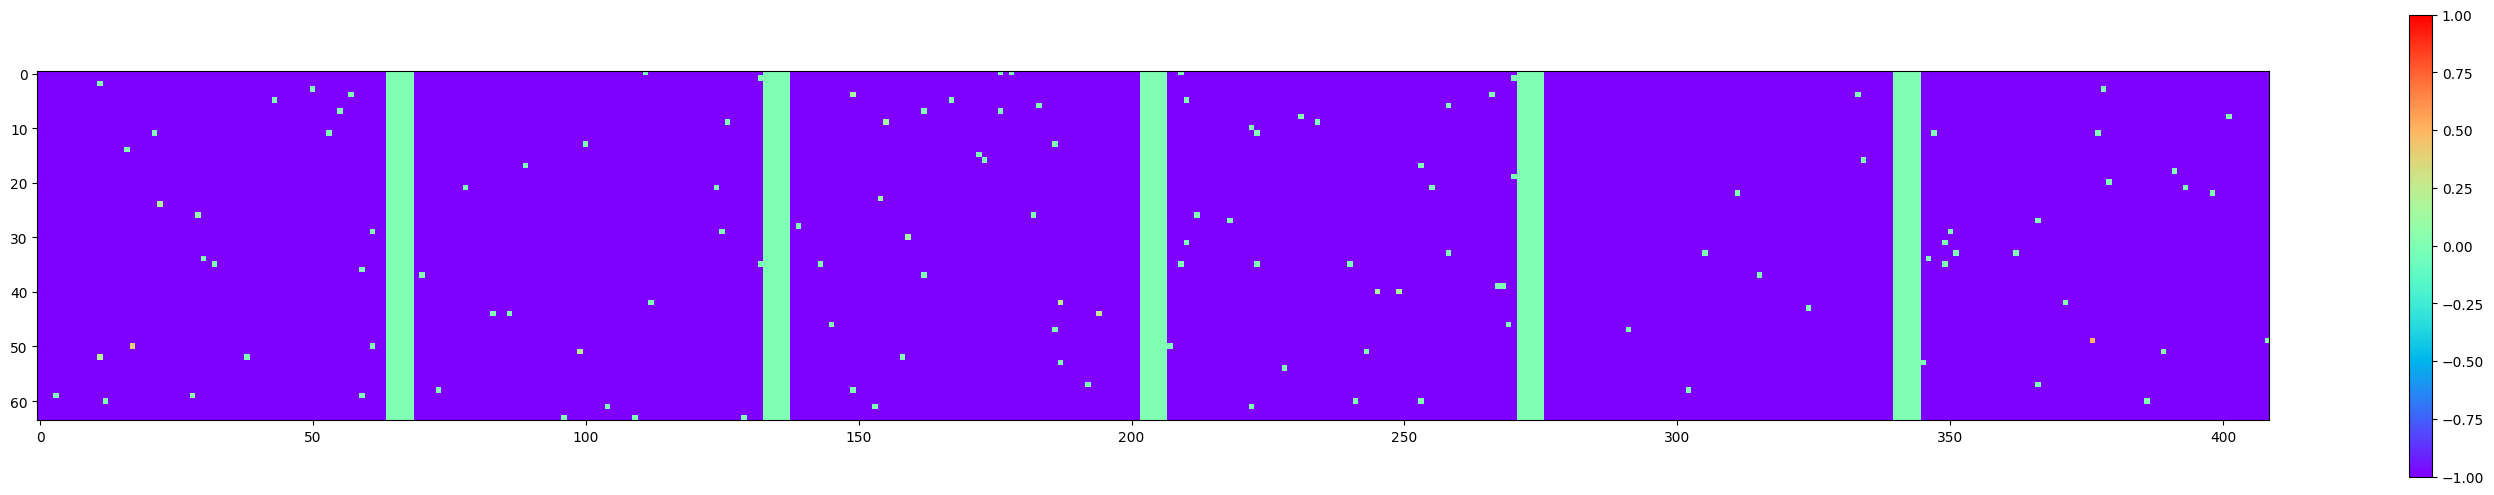

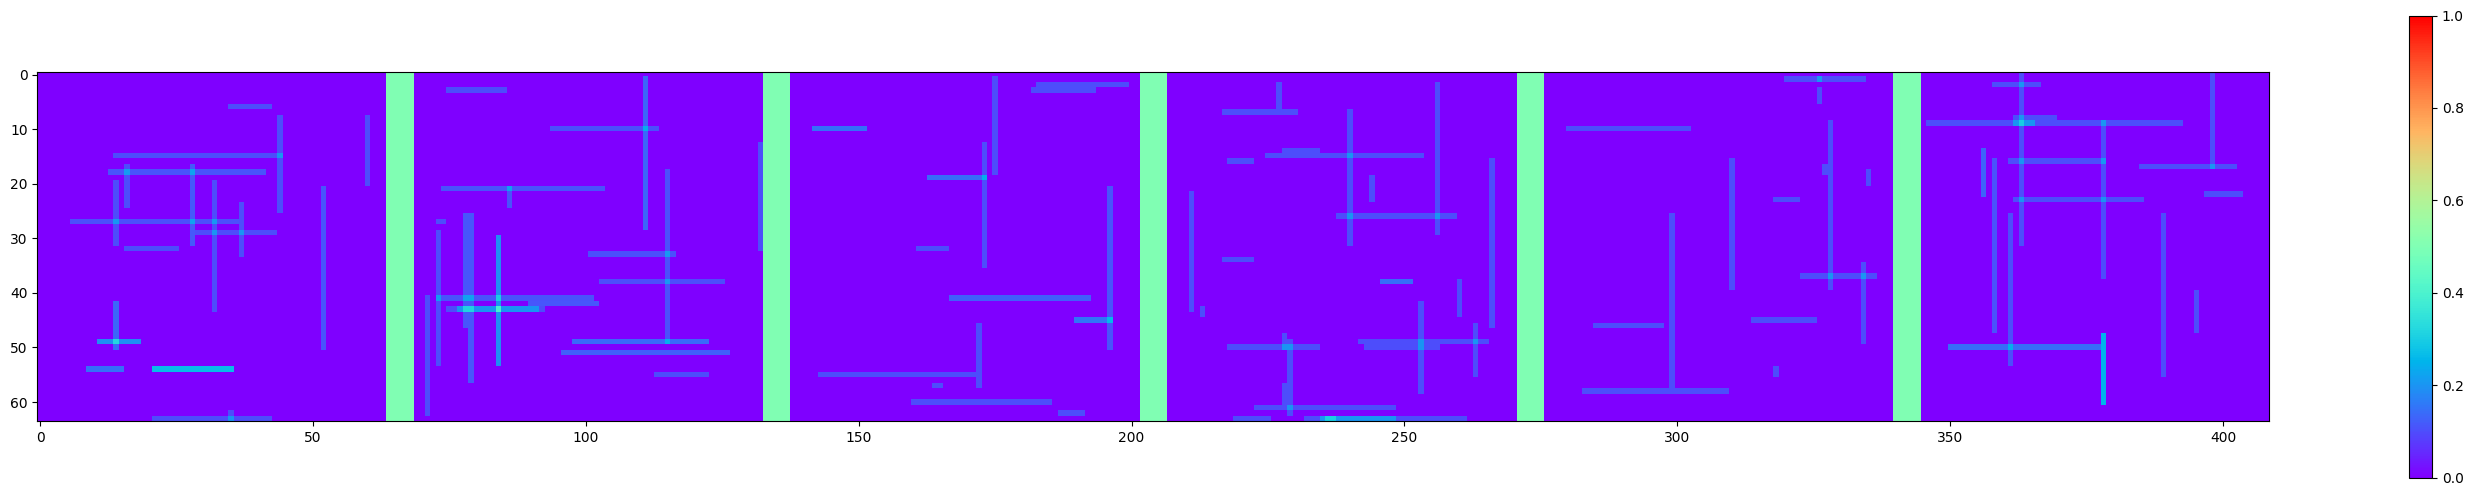

In [66]:
batch_size = 6
p = 0.5 / 100
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures ponctuelles
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_target, 6, fig2, k=0, min_scale=-1, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale=0, max_scale=1)

Dans la cellule précédente, la fonction *gen_image_with_integrated_signals* permet de visualiser le jeu simulé:
- *full_target* représente le champ $T$ vu par le premier type de capteur spécifique sur la zone couverte par l'image. Il s'agit de disques de valeurs positives.
- *partial_target* représente les mesures ponctuelles. En dehors des points de mesure, la valeur est fixée à -1.
- *integrated_signals* contient la représentation par segments. En dehors des segments, la valeur est fixée à 0. Dans cette simulation simpliste, les segments ont tous été supposés parallèles à l'un des deux côtés de l'image. De plus, $S$ a été modélisé comme une fonction affine, croissante de la valeur moyenne sur le segment. Ainsi, l'intensité d'un segment croit avec le nombre de disques traversés.

Dans cette partie, le but est de dire:\
**A.** si l'on peut entraîner avec succès un *FCN* à restituer $T$ **à partir** de données d'opportunité représentées par des segments (**exercice 1**).\
**B.** si en combinant des données d'opportunité aux mesures ponctuelles, on améliore bien les performances d'un $FCN$ (**exercice 2**).

**Exercice 1**

**Q1** Dans la cellule suivante, instancier un UNet. Choisir correctement *ch_in* et *ch_out*.

In [67]:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in, ch_out, size).cuda()

In [68]:
fcn

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=

**Q2** Combien de poids ce réseau contient-il ? Ecrire le calcul ou intégrer un bout de code qui conduit au résultat.

In [69]:
pconv=0
pconvt=0
pbn=0
ptot=0

for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      for parameter in module.parameters():
        pconv += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.ConvTranspose2d):
      for parameter in module.parameters():
        pconvt += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.BatchNorm2d):
      for parameter in module.parameters():
        pbn += torch.numel(parameter)

print(pconv)  # number of weights in convolution layers
print(pconvt) #  " " in transpose convolution layers
print(pbn)    # number of weights in BatchNorm layers

print('Total weights',pconv + pconvt + pbn)

209674
21880
992
Total weights 232546


\**Q3** Présenter brièvement les types de couches utilisées dans ce

---

réseau.

Conv2d : Il s'agit d'une couche de convolution 2D. Elle est utilisée pour appliquer un filtre convolutif aux données d'entrée, permettant de détecter des caractéristiques locales dans les images.

BatchNorm2d : La normalisation par lots (Batch Normalization) est une technique pour améliorer la stabilité et les performances du réseau. Elle normalise les entrées de chaque mini-lot pour avoir une moyenne de 0 et une variance de 1.

ReLU : ReLU (Rectified Linear Unit) est une fonction d'activation non linéaire qui est appliquée après chaque couche de convolution. Elle remplace toutes les valeurs négatives dans le vecteur d'entrée par zéro.

MaxPool2d : La couche de Max Pooling est utilisée pour réduire les dimensions spatiales (hauteur et largeur) de l'entrée, ce qui aide à réduire le surapprentissage et à diminuer la complexité computationnelle.

ConvTranspose2d : Cette couche effectue la transposition de convolution (également appelée deconvolution). Dans le contexte du UNet, elle est utilisée pour augmenter la résolution spatiale des caractéristiques extraites, ce qui est essentiel dans les couches de "upscaling" du réseau.

**Q4** Dans la cellule suivante, coder en une ligne l'erreur absolue moyenne (MAE).

In [70]:
def criterion(output,target):
  return torch.mean(torch.abs(target-output))

**Q5** Instancier l'optimizer Adam avec un taux d'apprentissage de 0.0002.

In [71]:
optimizer = optim.Adam(fcn.parameters(), 0.0002)

**Q6** Pourquoi est-il, en général, nécessaire de passer par une étape de validation lors d'un apprentissage ? Pourquoi peut-on s'en passer dans le cas où les images sont générées la volée ?


 La validation permet d'évaluer la performance du modèle sur des données qu'il n'a pas vues pendant l'entraînement. Cela donne une indication de la capacité du modèle à généraliser à de nouvelles données.

 Cependant, dans le cas où les images sont générées à la volée
, l'utilisation d'une étape de validation traditionnelle peut être moins critique. Cela est dû au fait que les données générées peuvent être adaptées à l'infini, et la notion de surajustement peut être moins préoccupante. Néanmoins, il est toujours utile d'avoir une évaluation quantitative de la qualité des images générées pour s'assurer que le modèle apprend correctement la distribution des données souhaitée.

**Q7** Ecrire la boucle d'apprentissage. On stockera la MAE à chaque époque.
- nombre d'époque : 30
- batches par époque : 100
- taille de batch : 32

In [72]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses = []

fcn = fcn.cuda()

for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)
        inputs = integrated_signals.cuda()
        targets = full_target.cuda()

        optimizer.zero_grad()  # Zero the gradients
        outputs = fcn(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del targets, inputs, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.36443406
Epoch 1
epoch loss : 

0.20586894
Epoch 2
epoch loss : 

0.12361815
Epoch 3
epoch loss : 

0.071515046
Epoch 4
epoch loss : 

0.054046698
Epoch 5
epoch loss : 

0.047240637
Epoch 6
epoch loss : 

0.043585725
Epoch 7
epoch loss : 

0.04081037
Epoch 8
epoch loss : 

0.04227933
Epoch 9
epoch loss : 

0.04039814
Epoch 10
epoch loss : 

0.040427923
Epoch 11
epoch loss : 

0.0385404
Epoch 12
epoch loss : 

0.03814327
Epoch 13
epoch loss : 

0.03770343
Epoch 14
epoch loss : 

0.03751947
Epoch 15
epoch loss : 

0.03772546
Epoch 16
epoch loss : 

0.0371857
Epoch 17
epoch loss : 

0.03560766
Epoch 18
epoch loss : 

0.035489623
Epoch 19
epoch loss : 

0.03578207
Epoch 20
epoch loss : 

0.03497981
Epoch 21
epoch loss : 

0.03507067
Epoch 22
epoch loss : 

0.035655845
Epoch 23
epoch loss : 

0.033980645
Epoch 24
epoch loss : 

0.03393145
Epoch 25
epoch loss : 

0.034388795
Epoch 26
epoch loss : 

0.033638082
Epoch 27
epoch loss : 

0.03335881
Epoch 28
epoch loss : 

**Q8** Visualisez les résultats. Quelle conséquence visible le choix de la fonction de coût a-t-il eu ? Conclure sur le point **A.**

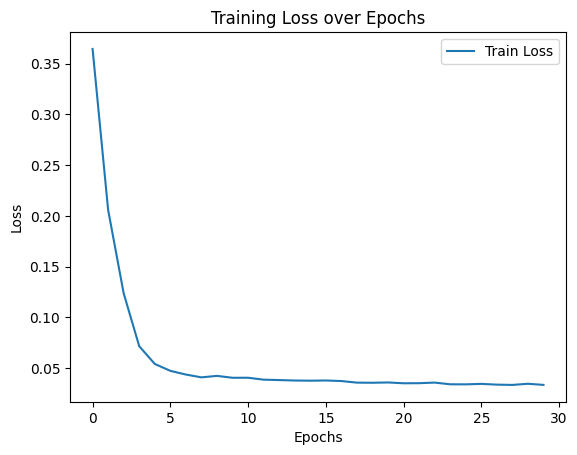

In [73]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

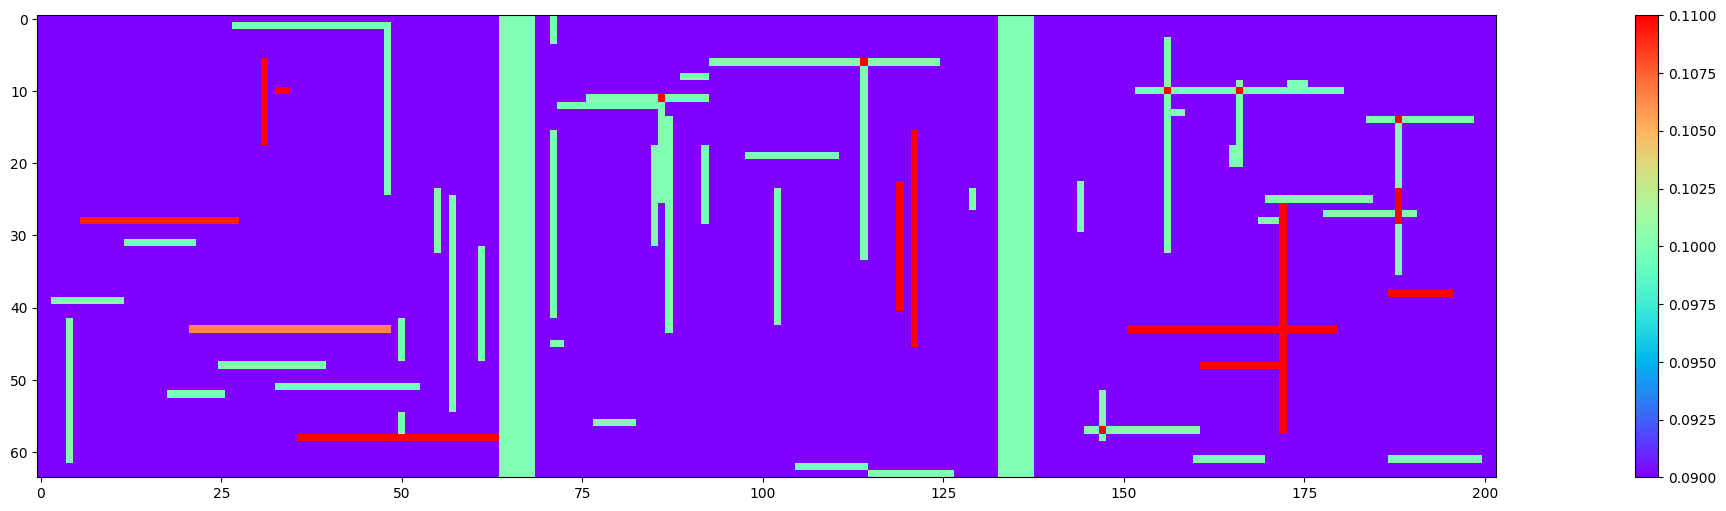

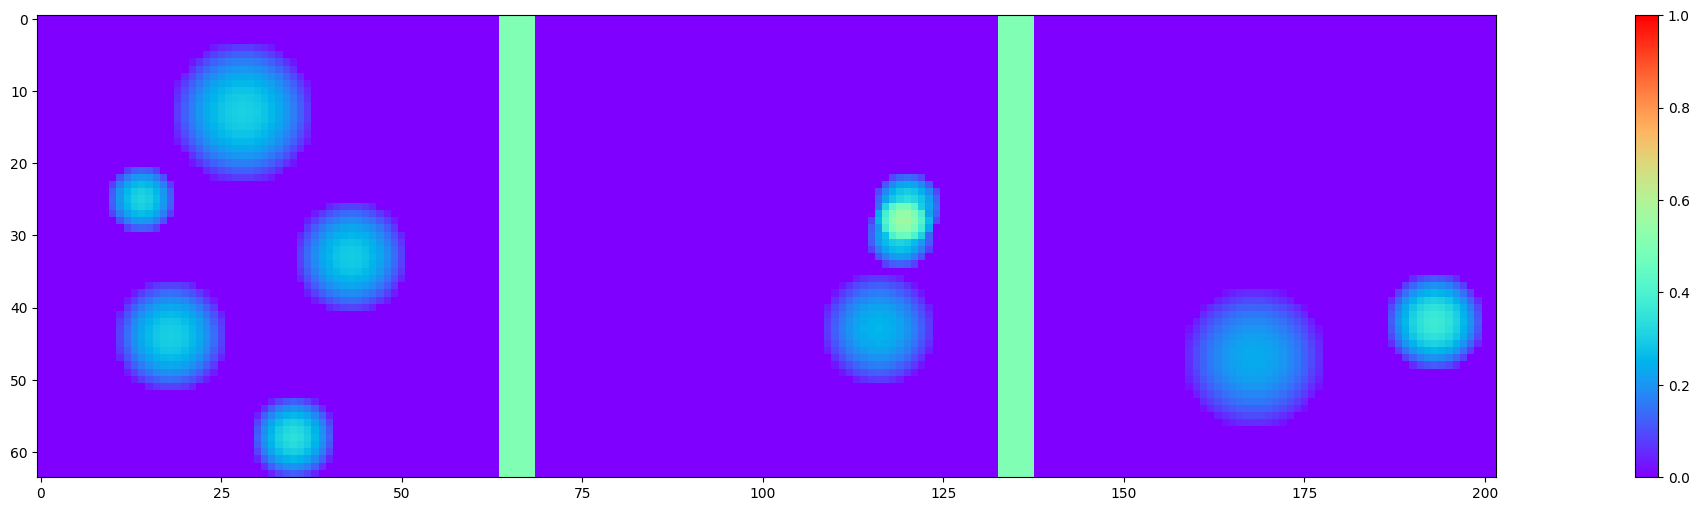

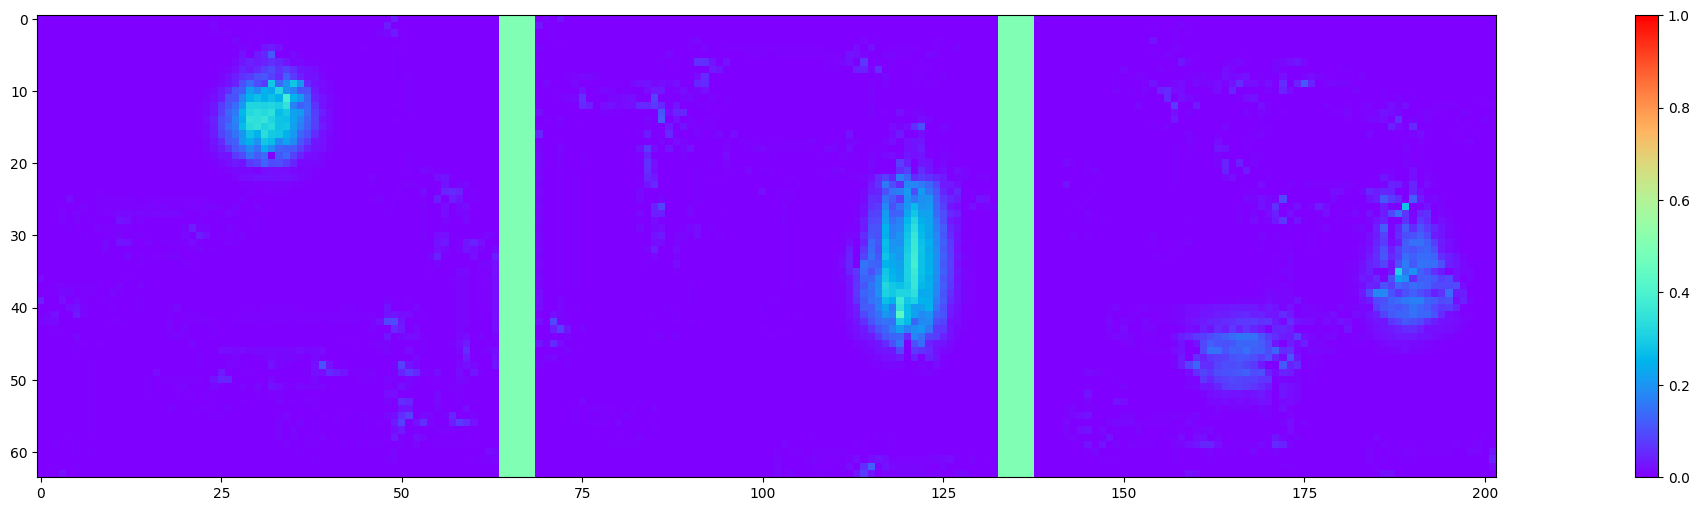

In [74]:
#visualisation des résultats:

fcn.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input = integrated_signals.cuda()

output = fcn(input)

fig = plt.figure(0, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale= 0.09,max_scale=0.11)
fig2 = plt.figure(1, figsize=(36, 6))  #seconde ligne: vérité terrain

voir_batch2D(full_target, 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1.)

**Exercice 2**

On souhaite montrer qu'un *fcn* peut utiliser simultanément les deux types de signaux (mesures ponctuelles et données d'opportunité).
Reprendre le code de **l'exercice 1** avec les deux champs en entrée. Comparer les performances aux plans quantitatif (courbes d'apprentissage) et qualitatif. Conclure.

In [75]:
ch_in = 2
ch_out = 1
size = 8

fcn2 = UNet(ch_in, ch_out, size).cuda()

In [76]:
def criterion(output,target):
  return torch.mean(torch.abs(target-output))

In [77]:
optimizer = optim.Adam(fcn.parameters(), 0.0002)

In [78]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses2 = []

fcn2 = fcn2.cuda()

for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)
        inputs1 = integrated_signals.cuda()
        inputs2 = partial_target.cuda()
        targets = full_target.cuda()

        optimizer.zero_grad()  # Zero the gradients
        inputs = torch.cat((inputs1,inputs2),dim =1)
        outputs = fcn2(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del targets, inputs1,inputs2, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses2.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.26336157
Epoch 1
epoch loss : 

0.26316226
Epoch 2
epoch loss : 

0.26388034
Epoch 3
epoch loss : 

0.26374388
Epoch 4
epoch loss : 

0.26288143
Epoch 5
epoch loss : 

0.26421785
Epoch 6
epoch loss : 

0.26317063
Epoch 7
epoch loss : 

0.2623491
Epoch 8
epoch loss : 

0.2625386
Epoch 9
epoch loss : 

0.2633168
Epoch 10
epoch loss : 

0.2635606
Epoch 11
epoch loss : 

0.26263705
Epoch 12
epoch loss : 

0.26370794
Epoch 13
epoch loss : 

0.26367423
Epoch 14
epoch loss : 

0.26397014
Epoch 15
epoch loss : 

0.26415098
Epoch 16
epoch loss : 

0.2628119
Epoch 17
epoch loss : 

0.2642869
Epoch 18
epoch loss : 

0.26461828
Epoch 19
epoch loss : 

0.26304862
Epoch 20
epoch loss : 

0.26308832
Epoch 21
epoch loss : 

0.26392606
Epoch 22
epoch loss : 

0.26413396
Epoch 23
epoch loss : 

0.26369417
Epoch 24
epoch loss : 

0.26272082
Epoch 25
epoch loss : 

0.26353607
Epoch 26
epoch loss : 

0.26337606
Epoch 27
epoch loss : 

0.26390588
Epoch 28
epoch loss : 

0.26383126
E

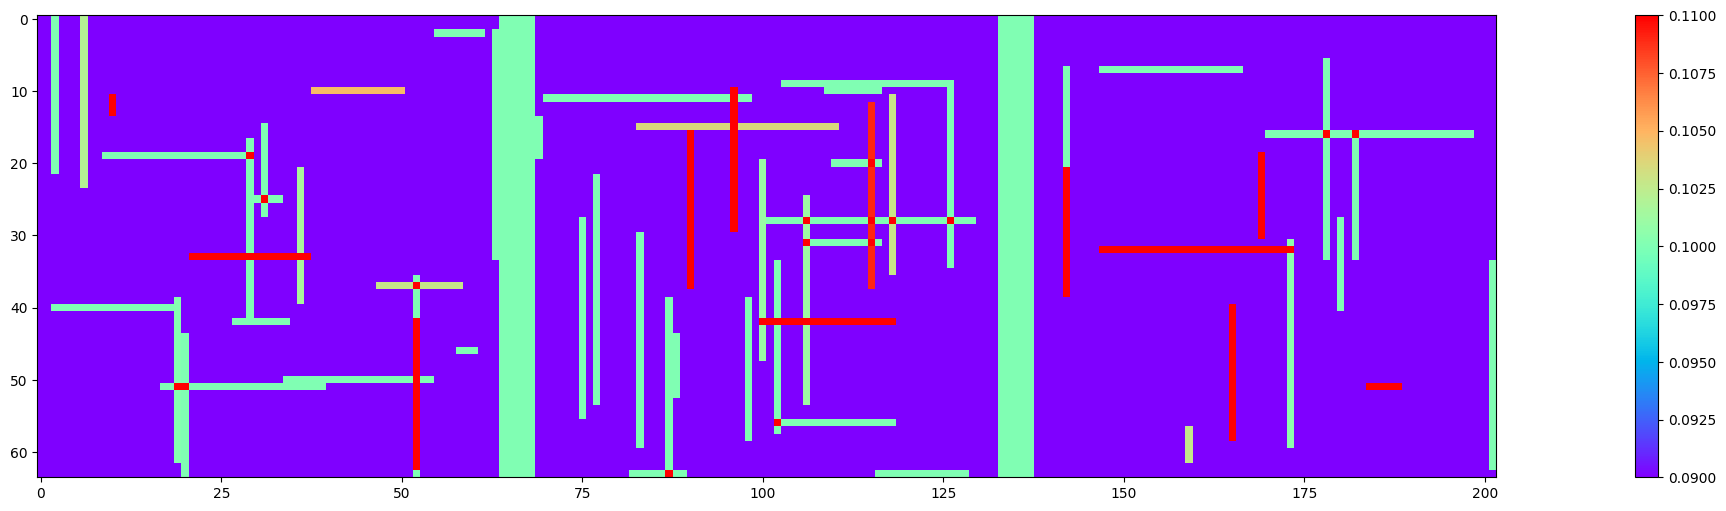

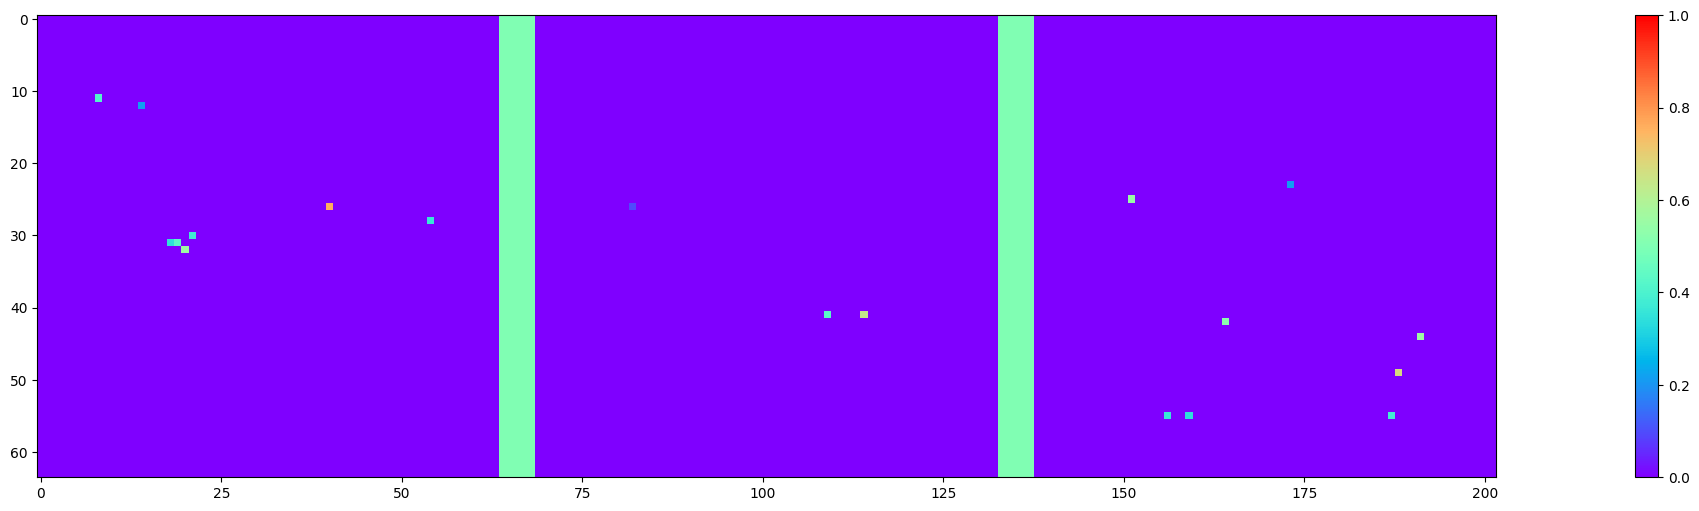

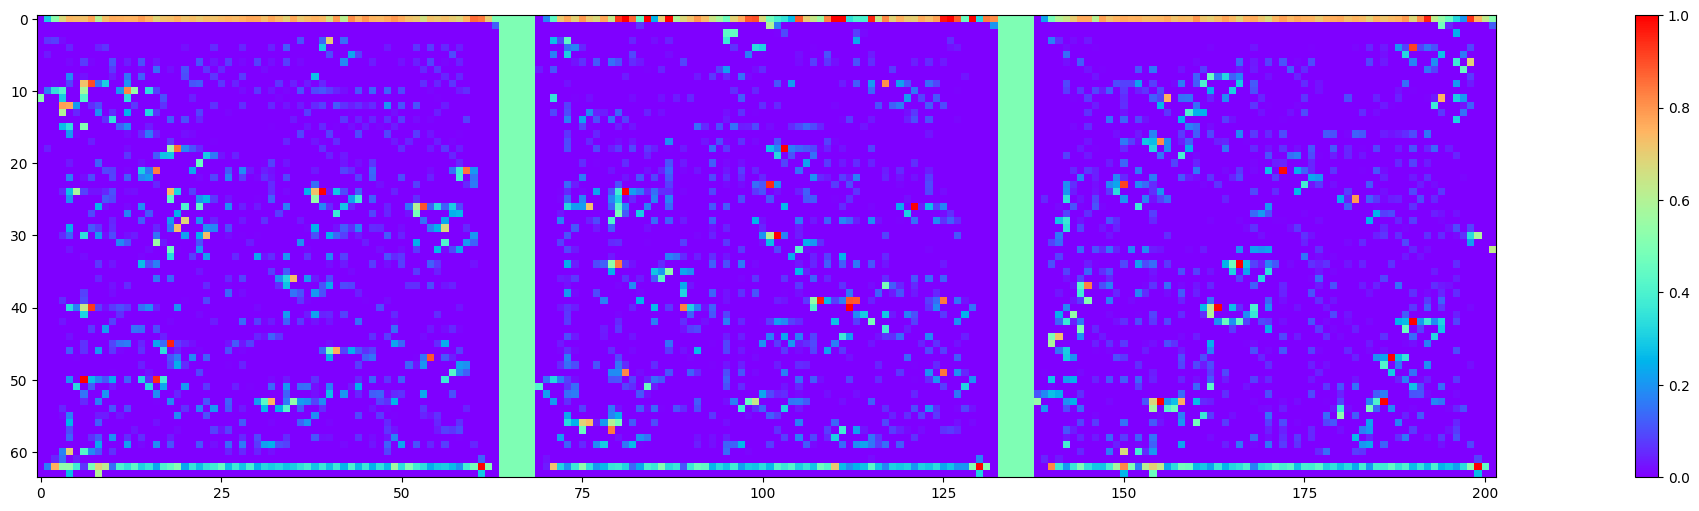

In [80]:
#visualisation des résultats:

fcn2.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input1 = integrated_signals.cuda()
input2 = partial_target.cuda()
input = torch.cat((input1,input2),dim =1)
output = fcn2(input)

fig = plt.figure(0, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale= 0.09,max_scale=0.11)
fig2 = plt.figure(1, figsize=(36, 6))  #seconde ligne: vérité terrain

voir_batch2D(full_target + partial_target , 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output.detach().cpu() , 6, fig2, k=0, min_scale=0,max_scale=1.)

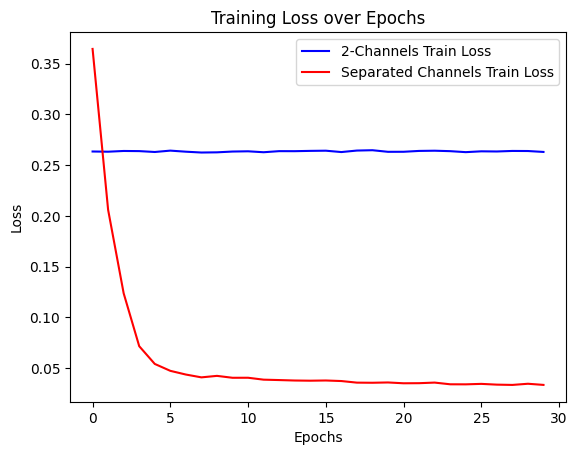

In [81]:
plt.plot(train_losses2, label='2-Channels Train Loss', color='blue')
plt.plot(train_losses, label='Separated Channels Train Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()
